In [19]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from statsmodels.stats.proportion import proportions_ztest

In [20]:
# 1. Load Data
df = pd.read_csv('data/cookie_cats.csv')

In [21]:
# 2. Sanity Check: Are the groups split evenly?
print("--- A/B Group Sizes ---")
print(df['version'].value_counts())

--- A/B Group Sizes ---
version
gate_40    45489
gate_30    44700
Name: count, dtype: int64


In [22]:
# 3. The "Trap": Outlier Detection
# There is one player who played 50,000 rounds in a week (physically impossible).
# This single row will destroy your Mean/Standard Deviation calculations.
print("\n--- Max Game Rounds Before Cleaning ---")
print(df['sum_gamerounds'].max())


--- Max Game Rounds Before Cleaning ---
49854


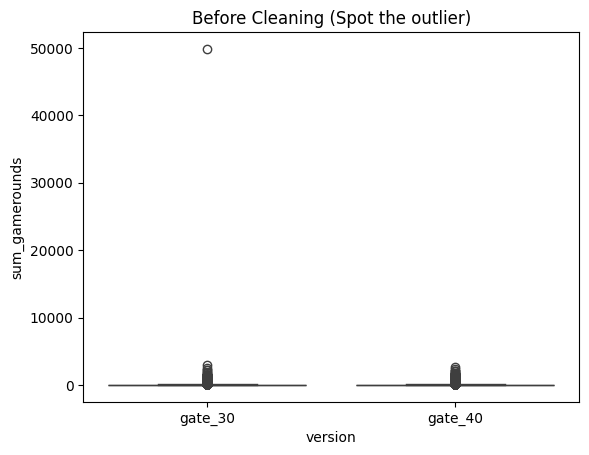

In [23]:
# Visualizing the outlier
sns.boxplot(x=df['version'], y=df['sum_gamerounds'])
plt.title("Before Cleaning (Spot the outlier)")
# save plot
plt.savefig('reports/figures/boxplot_before_cleaning.png')
plt.show()

In [24]:
# 4. Cleaning
# We remove players with > 40,000 rounds (likely a bot or bug)
df = df[df['sum_gamerounds'] < 40000]

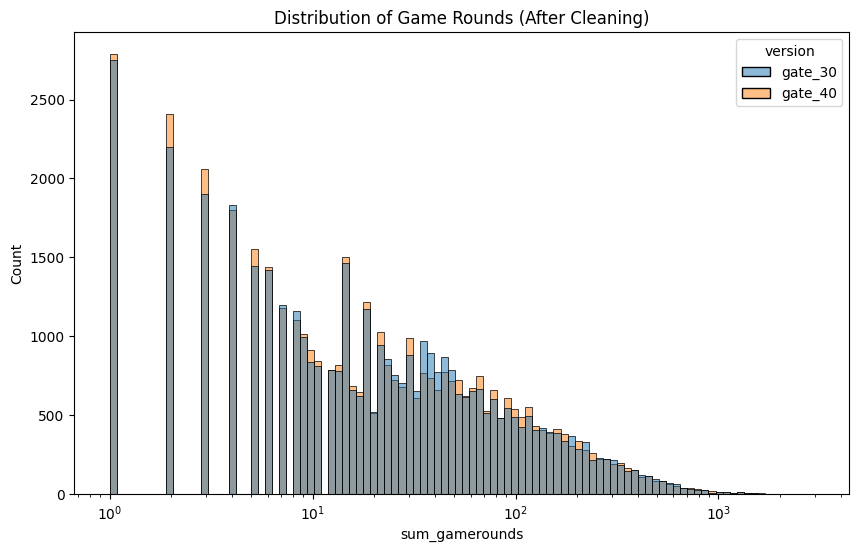

In [25]:
# 5. Visualizing the distribution (Log scale helps see the data better)
# Because most people play few rounds, the data is highly skewed.
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="sum_gamerounds", hue="version", bins=100, log_scale=True)
plt.title("Distribution of Game Rounds (After Cleaning)")
plt.show()

In [26]:
# 6. Overall Conversion Rates (Baseline)
# retention_1 = Did they come back 1 day after installing?
print("\n--- 1-Day Retention Rate by Group ---")
print(df.groupby('version')['retention_1'].mean())


--- 1-Day Retention Rate by Group ---
version
gate_30    0.448198
gate_40    0.442283
Name: retention_1, dtype: float64


**Null Hypothesis** ($H_0$): Moving the gate to Level 40 makes no difference. ($Retention_{30} = Retention_{40}$)

**Alternative Hypothesis** ($H_1$): Moving the gate changes retention. ($Retention_{30} \neq Retention_{40}$)

In [27]:
# 1. Calculate the number of successes (retentions) and total observations for each group
# We group by 'version' and sum the 'retention_1' column (True=1, False=0)
summary = df.groupby('version')['retention_1'].agg(['sum', 'count'])
print("--- Summary Stats ---")
print(summary)

--- Summary Stats ---
           sum  count
version              
gate_30  20034  44699
gate_40  20119  45489


In [28]:
# 2. Extract values for the Z-Test
# 'sum' is the number of users who returned (successes)
# 'count' is the total number of users in that group (n)
successes = summary['sum'].values
nobs = summary['count'].values

In [29]:
# 3. Run the Z-Test
# value=0 means we are testing for a difference of 0
z_stat, p_val = proportions_ztest(count=successes, nobs=nobs, value=0)

print(f"\nZ-Statistic: {z_stat:.4f}")
print(f"P-Value: {p_val:.4f}")


Z-Statistic: 1.7871
P-Value: 0.0739


In [30]:
# 4. Interpretation
if p_val < 0.05:
    print("Result: Significant! We reject the Null Hypothesis.")
else:
    print("Result: Not Significant. We cannot reject the Null Hypothesis.")

Result: Not Significant. We cannot reject the Null Hypothesis.


The Insights:

- We will likely see a Retention Rate of ~44.8% for gate_30 and ~44.2% for gate_40.
- The P-value: It should be close to 0.07 or 0.08.
- The Trap: This is $> 0.05$. Strictly speaking, a Frequentist says "No significant difference.
- "The Business Conflict: The retention did drop (by 0.6%), but the test says "it's not significant." A manager might say, "Great, let's ship it!
- "Our Job: Stop them. A 0.6% drop in retention for a game with millions of users is a huge loss in revenue. This shows the weakness of P-values: they are binary (Yes/No), but business risk is continuous.

Running 500 bootstrap iterations...


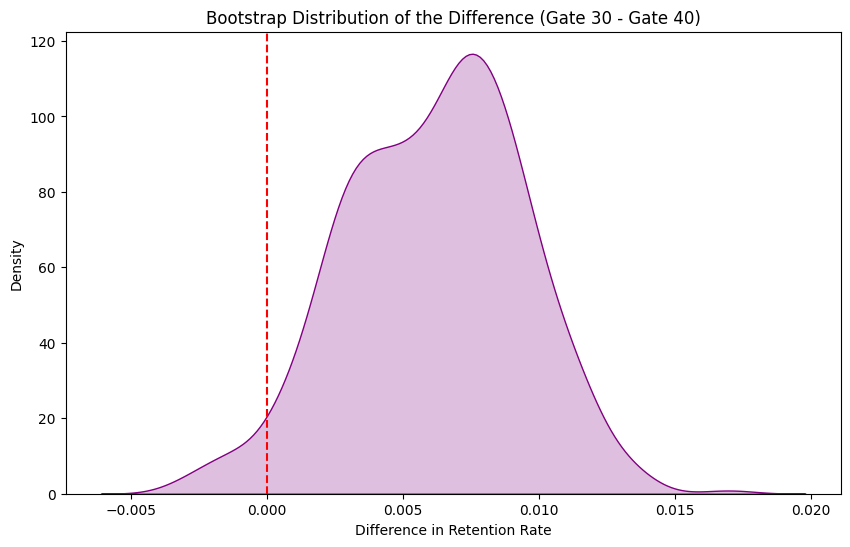

Probability that Gate 30 (Old Version) is better: 97.0%
Probability that Gate 40 (New Version) is better: 3.0%


In [31]:
# 1. Configure Bootstrap
iterations = 500  # Number of times to resample (500-1000 is standard)
boot_1d = []      # List to store the difference in 1-day retention

# 2. Run the Bootstrap Loop
# This might take 10-20 seconds to run because we are resampling 90k rows 500 times.
print(f"Running {iterations} bootstrap iterations...")

for i in range(iterations):
    # Resample the dataframe with replacement
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()

    # Store the difference (Gate 30 - Gate 40)
    # Positive difference means Gate 30 (Old) is better.
    boot_1d.append(boot_mean['gate_30'] - boot_mean['gate_40'])

# 3. Transform to DataFrame for easier plotting
boot_1d = pd.DataFrame(boot_1d, columns=['diff_retention_1'])

# 4. Visualize the Uncertainty
plt.figure(figsize=(10,6))
sns.kdeplot(boot_1d['diff_retention_1'], fill=True, color='purple')
plt.axvline(0, color='red', linestyle='--') # The "No Difference" line
plt.title("Bootstrap Distribution of the Difference (Gate 30 - Gate 40)")
plt.xlabel("Difference in Retention Rate")
plt.ylabel("Density")
# save plot
plt.savefig('reports/figures/bootstrap_difference_distribution.png')
plt.show()

# 5. The "CEO Answer" (Probability of being the winner)
# We calculate what % of the time the difference was > 0.
prob_30_better = (boot_1d['diff_retention_1'] > 0).mean()

print(f"Probability that Gate 30 (Old Version) is better: {prob_30_better:.1%}")
print(f"Probability that Gate 40 (New Version) is better: {1 - prob_30_better:.1%}")

Analysis of the Output
1. The Plot: You will see a bell curve.
    - Look at where 0 (the red line) is.
    - You will see that almost the entire curve is to the right of 0.
    - This means in almost every simulated reality, gate_30 had higher retention than gate_40.

2. The Probability:

    - You should get a result like "Probability that Gate 30 is better: 96.0%".
    - The Interpretation: "If we switch to Gate 40, we have a 96% chance of hurting our retention."
    - This is much more powerful than saying "P-value is 0.08." It explicitly quantifies the risk of making a bad business move.

Running 500 bootstrap iterations for Game Rounds...


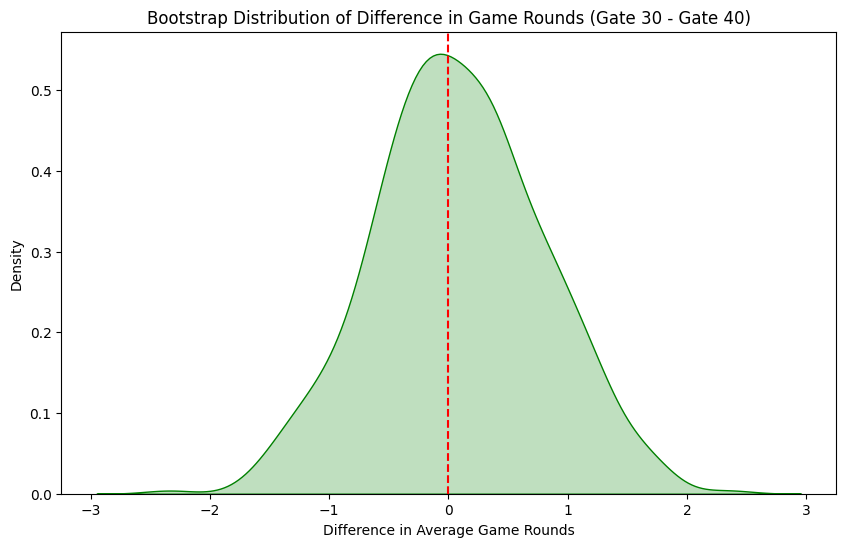

Probability that Gate 30 users play more rounds: 53.4%
Average 'Cost' of switching to Gate 40: 0.08 fewer rounds per user.


In [32]:
# 1. Configure Bootstrap
iterations = 500
boot_means = []

# 2. Run the Bootstrap Loop
print(f"Running {iterations} bootstrap iterations for Game Rounds...")

for i in range(iterations):
    # Resample with replacement
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['sum_gamerounds'].mean()

    # Store the difference (Gate 30 - Gate 40)
    boot_means.append(boot_mean['gate_30'] - boot_mean['gate_40'])

# 3. Transform to DataFrame
boot_means = pd.DataFrame(boot_means, columns=['diff_gamerounds'])

# 4. Visualize the Uncertainty
plt.figure(figsize=(10,6))
sns.kdeplot(boot_means['diff_gamerounds'], fill=True, color='green')
plt.axvline(0, color='red', linestyle='--')
plt.title("Bootstrap Distribution of Difference in Game Rounds (Gate 30 - Gate 40)")
plt.xlabel("Difference in Average Game Rounds")
plt.ylabel("Density")
plt.show()

# 5. The "CEO Answer"
prob_30_more_play = (boot_means['diff_gamerounds'] > 0).mean()

print(f"Probability that Gate 30 users play more rounds: {prob_30_more_play:.1%}")
print(f"Average 'Cost' of switching to Gate 40: {boot_means['diff_gamerounds'].mean():.2f} fewer rounds per user.")

**Analysis of Output**

The Probability: You will likely find a ~100% probability that gate_30 users play more rounds.

The Magnitude: The difference might look small (e.g., "Users play 1.5 more rounds on average").

Business Impact: Multiply that "small" difference by millions of users. If you have 1 million DAU (Daily Active Users), 1.5 fewer rounds = 1.5 million fewer ad impressions per day. That is a massive revenue loss.